<a href="https://colab.research.google.com/github/JackBstn/NLP/blob/test/mv_chronos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install torch transformers chronos yfinance pandas matplotlib
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-wz3f12r1
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-wz3f12r1
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 28e7b3281f68d1493a6290b3aa32902128ad2157
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Variance: [  4.5395927   7.8084564   8.279922    6.9867454  10.776463   25.127079
  31.449244   46.423977   39.33399    47.254654   63.14987    55.606384
  62.41349    69.377754   85.36278   104.81877   121.67946   125.16374
 130.01315   144.96097   157.49748   159.47324   172.93927   184.47458
 206.63358   215.07507   229.10686   273.26776   293.88666   325.713    ]


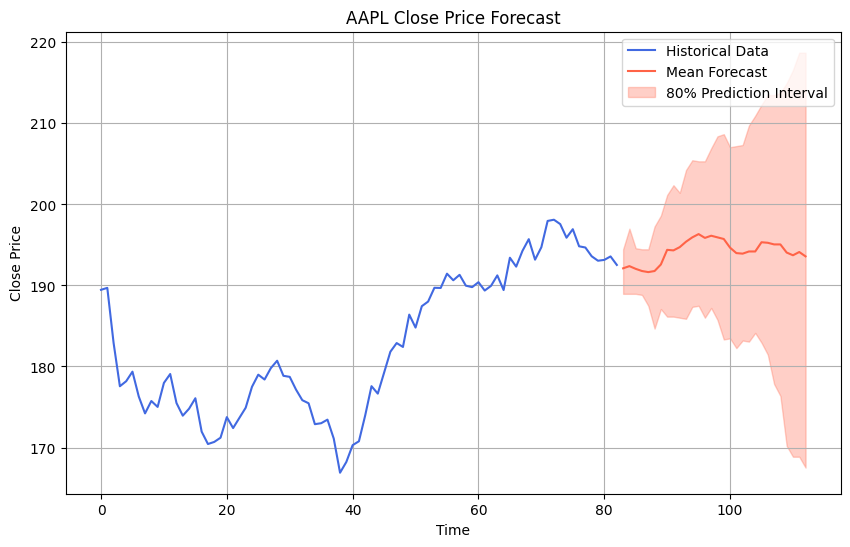

In [21]:
import pandas as pd
import yfinance as yf
import torch
from chronos import BaseChronosPipeline
import matplotlib.pyplot as plt
import numpy as np

seed = 343126
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

#Modello CHRONOS
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map="cuda", # cpu for CPU
    torch_dtype=torch.bfloat16,
)

#Dati da Yahoo Finance
symbol = "AAPL"  # Sostituisci con il simbolo dell'azione desiderata
data = yf.download(symbol, start="2023-09-01", end="2023-12-31", progress=False)

#Colonna 'Close' come serie temporale
df = data.reset_index()
close_prices = df["Close"].values.reshape(-1)

#Forecasting
forecast = pipeline.predict(
    context=torch.tensor(close_prices), prediction_length=30
)

#Visualizzazione
forecast_index = range(len(close_prices), len(close_prices) + 30)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
mean_forecast = np.mean(forecast[0].numpy(), axis=0)
variance_forecast = np.var(forecast[0].numpy(), axis=0)

print(f'Variance: {variance_forecast}')

plt.figure(figsize=(10, 6))
plt.plot(close_prices, color="royalblue", label="Historical Data")
plt.plot(forecast_index, mean_forecast, color="tomato", label="Mean Forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% Prediction Interval")
plt.title(f"{symbol} Close Price Forecast")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()

In [22]:
import pandas as pd
import yfinance as yf
import torch
from chronos import BaseChronosPipeline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # per dividere i dati in training e validation

seed = 343126
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

#Modello CHRONOS
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map="cuda", # cuda for CPU
    torch_dtype=torch.bfloat16,
)

#Dati da Yahoo Finance
symbol = "AAPL"  # Sostituisci con il simbolo dell'azione desiderata
data = yf.download(symbol, start="2010-01-01", end="2023-12-31", progress=False)

# Usa tutte le colonne come covariate
df = data.reset_index()
covariates = df[["Open", "High", "Low", "Volume"]].values  # Usa tutte le covariate
close_prices = df["Close"].values  # Variabile risposta

# Finestra mobile per generare il dataset
def generate_dataset_with_chronos(covariates, close_prices, pipeline, window_size=30):
    X = []
    Y = []
    for t in range(len(covariates) - window_size):
        # Finestra di covariate
        window = covariates[t:t+window_size]

        # Previsione con Chronos per ciascuna covariata
        means = []
        for i in range(window.shape[1]):  # Itera sulle variabili
            context = torch.tensor(window[:, i])  # Serie univariata
            forecast = pipeline.predict(context=context, prediction_length=1)  # Predice il giorno successivo
            mean_forecast = np.mean(forecast[0].numpy())  # Media della distribuzione
            means.append(mean_forecast)

        # Input: Medie delle covariate
        X.append(means)

        # Ground truth: Prezzo di chiusura reale del giorno successivo
        Y.append(close_prices[t+window_size])

    return np.array(X), np.array(Y)

# Genera il dataset
X_train, Y_train = generate_dataset_with_chronos(covariates, close_prices, pipeline)

# Print dataset size
print(f"Dataset size: {len(X_train)}")

# Normalizza covariate
scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)

# Normalizza variabile risposta
scaler_y = StandardScaler()
# Y_train = scaler_y.fit_transform(Y_train)

# Dividi i dati in training e validation
X_train_split, X_val_split, Y_train_split, Y_val_split = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=seed
)

# Converti in tensori PyTorch
X_train_split = torch.tensor(X_train_split, dtype=torch.float32)
X_val_split = torch.tensor(X_val_split, dtype=torch.float32)
Y_train_split = torch.tensor(Y_train_split, dtype=torch.float32).unsqueeze(1)  # Aggiungi dimensione target
Y_val_split = torch.tensor(Y_val_split, dtype=torch.float32).unsqueeze(1)  # Aggiungi dimensione target

Dataset size: 3492


In [23]:
import torch.nn as nn

class PricePredictionNN(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super(PricePredictionNN, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.relu1 = nn.ReLU()
            self.dropout1 = nn.Dropout(0.2)  # Add dropout
            self.fc2 = nn.Linear(hidden_size, hidden_size)  # Extra hidden layer
            self.relu2 = nn.ReLU()
            self.dropout2 = nn.Dropout(0.2)
            self.fc3 = nn.Linear(hidden_size, output_size)

        def forward(self, x):
            x = self.dropout1(self.relu1(self.fc1(x)))
            x = self.dropout2(self.relu2(self.fc2(x)))
            x = self.fc3(x)
            return x

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([2793, 1, 1])) that is different to the input size (torch.Size([2793, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([699, 1, 1])) that is different to the input size (torch.Size([699, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/5000, Testing Loss: 6641.2134, Validation Loss: 7016.2222
Epoch 2/5000, Testing Loss: 6637.3564, Validation Loss: 7012.7007
Epoch 3/5000, Testing Loss: 6634.6440, Validation Loss: 7009.1787
Epoch 4/5000, Testing Loss: 6630.9351, Validation Loss: 7005.6597
Epoch 5/5000, Testing Loss: 6627.3203, Validation Loss: 7002.1431
Epoch 6/5000, Testing Loss: 6624.3823, Validation Loss: 6998.6318
Epoch 7/5000, Testing Loss: 6620.9629, Validation Loss: 6995.1284
Epoch 8/5000, Testing Loss: 6617.5127, Validation Loss: 6991.6328
Epoch 9/5000, Testing Loss: 6614.1001, Validation Loss: 6988.1396
Epoch 10/5000, Testing Loss: 6610.8101, Validation Loss: 6984.6484
Epoch 11/5000, Testing Loss: 6607.5542, Validation Loss: 6981.1499
Epoch 12/5000, Testing Loss: 6604.0112, Validation Loss: 6977.6357
Epoch 13/5000, Testing Loss: 6600.5635, Validation Loss: 6974.1191
Epoch 14/5000, Testing Loss: 6597.4629, Validation Loss: 6970.5952
Epoch 15/5000, Testing Loss: 6594.1504, Validation Loss: 6967.0693
Epoc

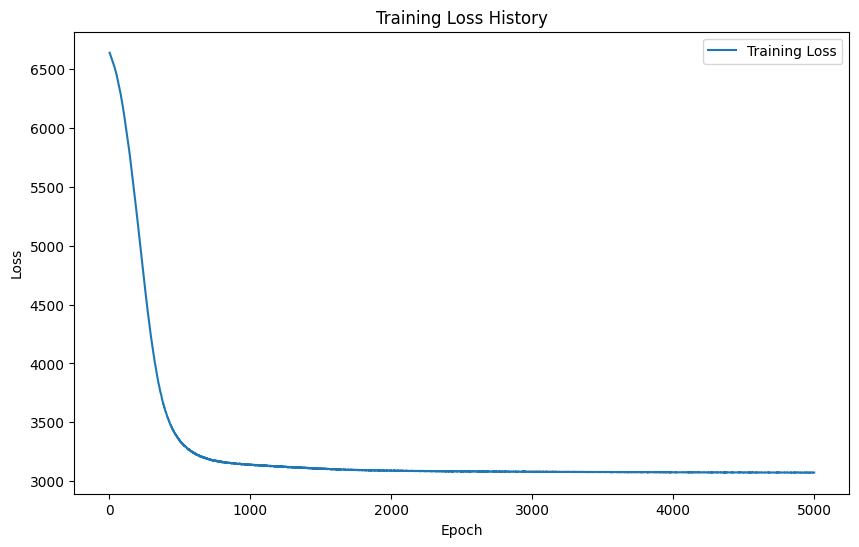

In [26]:
# Configurazione
input_size = X_train.shape[1]  # Numero di feature
hidden_size = 256  # Numero di unità nascoste
output_size = 1  # Prezzo di chiusura predetto
model = PricePredictionNN(input_size, hidden_size, output_size)

# Ottimizzatore e funzione di perdita
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()  # Mean Squared Error

# Early stopping
best_loss = float("inf")
patience = 500  # Numero massimo di epoche senza miglioramenti
patience_counter = 0

loss_history = []
loss_history_val = []

num_epochs = 5000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass sul training set
    predictions = model(X_train_split)
    loss = criterion(predictions, Y_train_split)

    # Backpropagation e aggiornamento
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    # Valutazione sul validation set
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_split)
        val_loss = criterion(val_predictions, Y_val_split)
        loss_history_val.append(val_loss.item())

    print(f"Epoch {epoch+1}/{num_epochs}, Testing Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

    # Early Stopping
    if val_loss.item() < best_loss:
        best_loss = val_loss.item()
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")  # Salva il miglior modello
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Plot the loss history
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history) + 1), loss_history, label="Training Loss")
plt.plot(range(1, len(loss_history_val) + 1), loss_history_val, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.show()

<ipython-input-27-194ad926f384>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


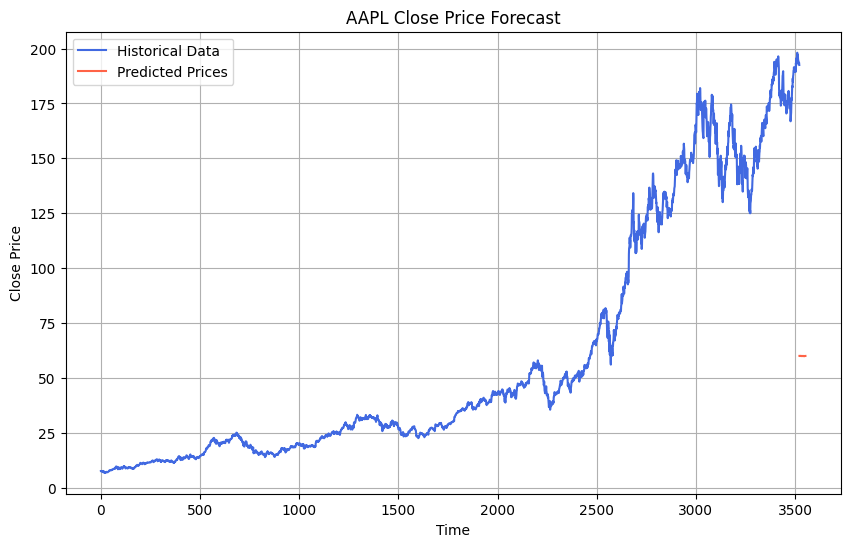

In [27]:
# Nuovi dati
new_data = yf.download(symbol, start="2024-01-01", end="2024-03-31", progress=False)
new_covariates = new_data[["Open", "High", "Low", "Volume"]].values
new_close_prices = new_data["Close"].values

# Genera dati di test con la finestra mobile
X_test, Y_test = generate_dataset_with_chronos(new_covariates, new_close_prices, pipeline)
X_test = scaler_x.transform(X_test)

# Converti in tensore
X_test = torch.tensor(X_test, dtype=torch.float32)

model.load_state_dict(torch.load("best_model.pth"))
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)

# test_predictions_original = scaler_y.inverse_transform(test_predictions)
test_predictions_original = test_predictions.numpy()

# Indici temporali per i dati storici e di test
historical_index = np.arange(len(close_prices))  # Dati storici
forecast_index = np.arange(len(close_prices), len(close_prices) + len(test_predictions))  # Previsioni

# Grafico
plt.figure(figsize=(10, 6))
plt.plot(historical_index, close_prices, color="royalblue", label="Historical Data")  # Storici
plt.plot(forecast_index, test_predictions_original, color="tomato", label="Predicted Prices")  # Previsioni
plt.title(f"{symbol} Close Price Forecast")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()